## In this notebook, Simulation 2D fringe pattern is being explored

### Written by: Zhiyuan Guo
### Last updated by: Zhiyuan Guo on 1/7/2021
### - Update notes: 
#### 6/24/2020 - Started the project 
#### 1/7/2021 - bandwidth included full wavelength (860-990nm) simulation generated

In [1]:
from mpl_toolkits import mplot3d

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import astropy.table
import astropy.units as u
import csv
import pandas as pd
import tmm
from Getindex import load_refraction_data

Populating the interactive namespace from numpy and matplotlib


In [3]:
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 183.)

In [4]:
def generate_heightfield(fractal_dimension=2.5, n=100, seed=123):

    H = 1 - (fractal_dimension - 2)
    kpow = -(H + 1.0) / 2.0
    
    A = np.zeros((n, n), complex)

    kvec = np.fft.fftfreq(n)
    k0 = kvec[n // 64]
    kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
    ksq = kx ** 2 + ky ** 2
    m = ksq > 0

    gen = np.random.RandomState(seed=seed)    
    phase = 2 * np.pi * gen.uniform(size=(n, n))
    A[m] = ksq[m] ** kpow * gen.normal(size=(n, n))[m] * np.exp(1.j * phase[m]) * np.exp(-ksq[m] / k0 ** 2)
    #print(A.shape)
    
    return np.fft.ifft2(A)


In [5]:
def E2V_model(d_si,d_si2,wlen = 800):
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    thickness_um = (np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14+d_si2,130, np.inf)

    # Assume normal incidence.
    theta = 0.

    # Define the wavelengths to calculate, matching the coverage of Figs. 3 and 4.
    #wlen_um = 1e-3 * wlen

    n_list = [index_of_refraction[m](wlen) for m in material]
    R = T = 0
    for pol in 'sp':

        # Using tmm package to do multilayer thin-film simulation
        result = tmm.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        R += 0.5*result['R']
        T += 0.5*result['T']

    A = 1 - R - T

    return(A)

In [6]:
x = range(100)
y = range(100)
X, Y = np.meshgrid(x, y)

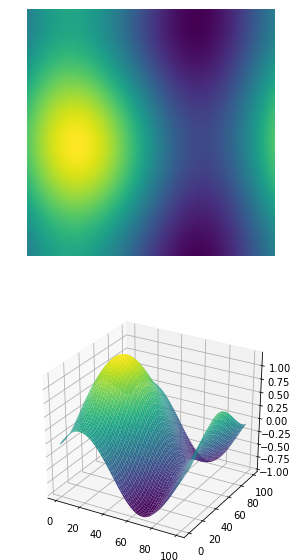

In [7]:
height_f2 = generate_heightfield(fractal_dimension= 2,seed = 1).real
hf = plt.figure(figsize = (5,10))
scale_factor2 = 1.2/np.max(height_f2)
h2d = hf.add_subplot(211)
h2d.imshow(height_f2,interpolation='bicubic')
h2d.axis('off')
#cb = plt.colorbar()
#cb.set_label(label='Thickness (um)', size='large', weight='bold')
ha = hf.add_subplot(212, projection='3d')

ha.plot_surface(X, Y, height_f2*scale_factor2,cmap='viridis');

In [39]:
# Define the gaussian function
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma

    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)

avg_wlen_width = 2
window =20

cen_wav = 960
x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)

# Assign weight to each point based on the gaussian
weight = gaussian(x,cen_wav,avg_wlen_width)
#plt.plot(x,weight,'o')

In [11]:
from tqdm import tqdm

In [40]:
Fringe_map = np.zeros_like(height_f2)
for k in tqdm(range(len(x))):
    for i in range(len(height_f2)):
        for j in range(len(height_f2)):
            Fringe_map[i,j]+= weight[k]*E2V_model(d_si = 0,d_si2= height_f2[i,j]*scale_factor2,wlen=x[k])
Fringe_map = Fringe_map/np.sum(weight)       


100%|██████████| 21/21 [03:18<00:00,  9.46s/it]


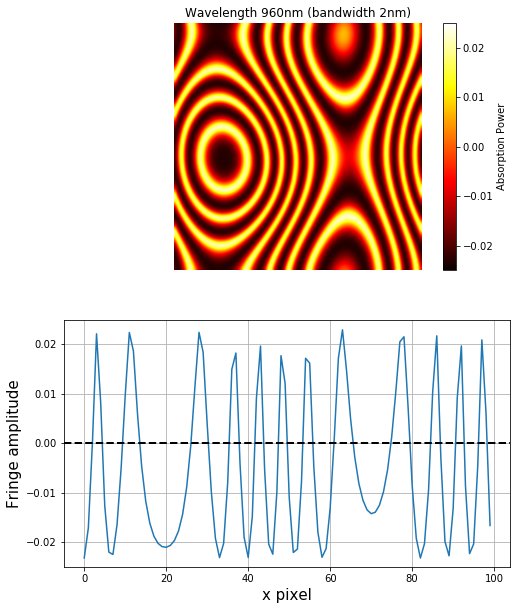

In [41]:
plt.figure(figsize = (8,10))
plt.subplot(211)
plt.title('Wavelength 960nm (bandwidth 2nm)')
a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
A = (Fringe_map)/a-1
plt.imshow(A,interpolation='bicubic',cmap = pylab.cm.hot,vmin = -0.025,vmax = 0.025)
cb = plt.colorbar(label = 'Absorption Power');
#cb.remove()

plt.axis('off');

plt.subplot(212)
#a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
#A = (Fringe_map)/a-1
plt.plot(A[60,:])
plt.axhline(0,ls = '--',color = 'black',linewidth = 2);
plt.ylim(-0.025,0.025)
plt.xlabel('x pixel',fontsize = 15)
plt.ylabel('Fringe amplitude',fontsize = 15)


plt.grid();
#plt.savefig('data/Sim/860.png')

In [32]:
cd ../..

/Users/zhiyuanguo/Documents/Research/Fringe Science/AstroCCD-master


In [34]:
import os
os.chdir('data/Sim/')
files = os.listdir()
files.sort()
if '.DS_Store' in files:
    files.remove('.DS_Store')
files

['860.png',
 '870.png',
 '880.png',
 '890.png',
 '900.png',
 '910.png',
 '920.png',
 '930.png',
 '940.png',
 '950.png',
 '960.png',
 '970.png',
 '980.png',
 '990.png',
 'movie.gif']

In [37]:
import imageio
images = [imageio.imread(file) for file in files]
imageio.mimwrite('movie.gif',images,fps = 7)